In [24]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pyvista as pv
from scipy.spatial import ConvexHull, Delaunay 
from tqdm.notebook import tqdm

from neural_fields_rbf.points import UnitSquare
from neural_fields_rbf.points.local_voronoi import LocalSurfaceVoronoi
from neural_fields_rbf.points.sphere import SpherePoints
from neural_fields_rbf.rbf.geometry import delaunay_covering_radius_stats
from neural_fields_rbf.rbf.quadrature import LocalQuad
from neural_fields_rbf.rbf.surface import SurfaceQuad, TriMesh
from neural_fields_rbf.rbf import PHS

# Basic usage in a flat domain
First generate some colocation nodes and construct a Delaunay triangulation.

Settling 500 points: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 812.63it/s]


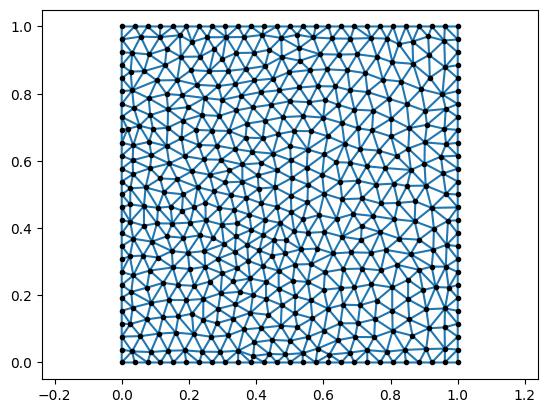

In [2]:
N = 500
points = UnitSquare(N, verbose=True).points
mesh = Delaunay(points)

plt.plot(*points.T, "k.")
plt.triplot(*points.T, mesh.simplices)
plt.axis("equal")
plt.show()

Choose RBF parameters and generate quadrature weights. We will use
$$\phi(r) = r^3$$
and append up to linear polynomials. The minimum stencil size is then $k = {3 \choose 2} = 3$ but this will make it so that all of our triangles are on the boundary of our stencils. To avoid this, we will take $k = 15$.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 894/894 [00:00<00:00, 1197.04it/s]


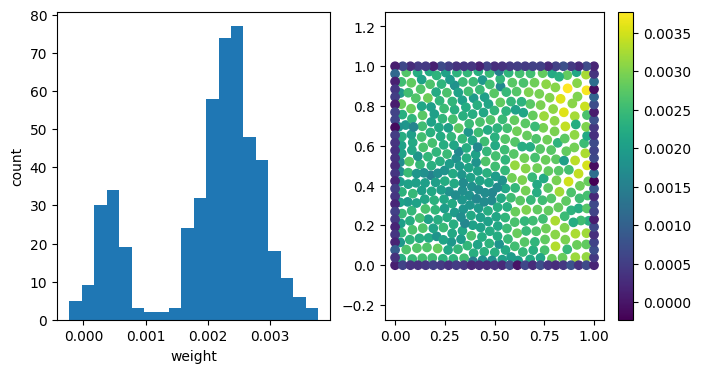

In [3]:
rbf = PHS(3)
poly_deg = 1
stencil_size = 15
quad = LocalQuad(
    points=points,
    rbf=rbf,
    poly_deg=poly_deg,
    stencil_size=stencil_size,
    verbose=True,
)


fig = plt.figure(figsize=(12, 4))
grid = GridSpec(1, 3)

ax_hist = fig.add_subplot(grid[0, 0])
ax_hist.hist(quad.weights, bins=20)
ax_hist.set_xlabel("weight")
ax_hist.set_ylabel("count")
ax_weights = fig.add_subplot(grid[0, 1])
im = ax_weights.scatter(*points.T, c=quad.weights, cmap="viridis")
fig.colorbar(im, ax=ax_weights)
_ = ax_weights.axis("equal")

Let's test this on a few functions
$$f_1(x,y) = x + y$$
$$f_2(x, y) = \sin(2\pi x) * \cos(3\pi x) + 1$$
each of which integrates to $1$ on the unit square.

As expected, the quadrature is exact for the linear function and works quite well for the trigonometric function.

In [4]:
def f1(points: np.ndarray[float]) -> np.ndarray[float]:
    x = points[:, 0]
    y = points[:, 1]
    return x + y

def f2(points: np.ndarray[float]) -> np.ndarray[float]:
    x = points[:, 0]
    y = points[:, 1]
    return np.sin(2*np.pi*x) * np.cos(3*np.pi * y) + 1

exact = 1.0

f1_approx = quad.weights @ f1(points)
print(f"f1 relative error = {np.abs(exact - f1_approx)/exact}")

f2_approx = quad.weights @ f2(points)
print(f"f2 relative error = {np.abs(exact - f2_approx)/exact}")

f1 relative error = 0.0
f2 relative error = 5.3376638155633316e-05


# Basic usage on a surface
First generate points on our surface and construct a triangulation.

/home/sage/Documents/python/uv_testing/.venv/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


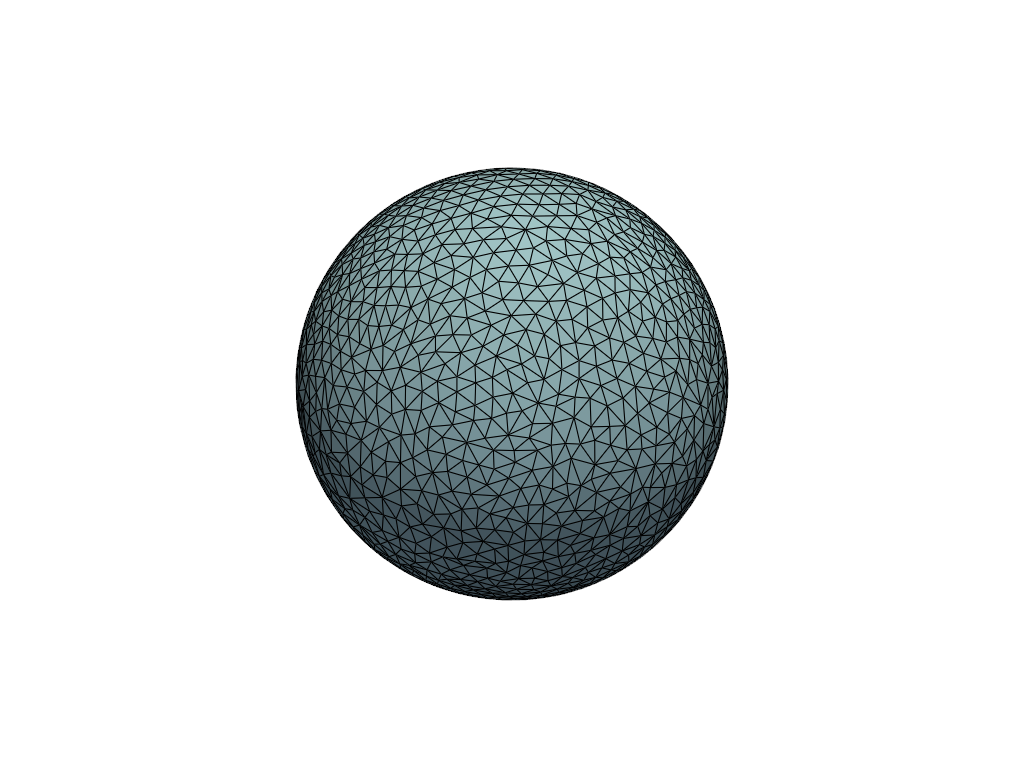

In [2]:
N = 2_000
sphere = SpherePoints(N, verbose=False)
hull = ConvexHull(sphere.points)

plotter = pv.Plotter()
plotter.add_mesh(
    pv.PolyData(sphere.points, [(3, *f) for f in hull.simplices]),
    show_edges=True,
)
plotter.show()

Choose RBF parameters and generate quadrature weights. We will use
$$\phi(r) = r^3$$
and append up to linear polynomials. The minimum stencil size is then $k = {3 \choose 2} = 3$ but this will make it so that all of our triangles are on the boundary of our stencils. To avoid this, we will take $k = 15$.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3996/3996 [00:05<00:00, 790.00it/s]


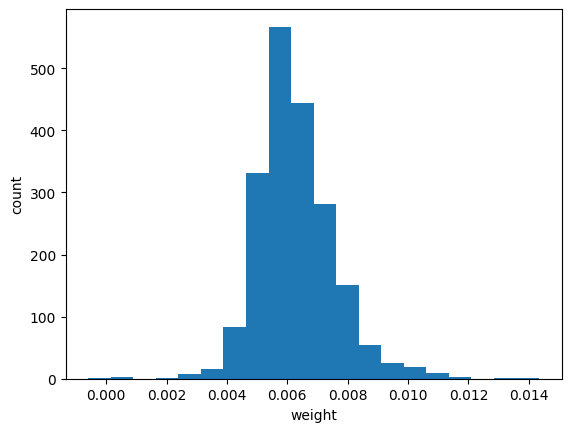

/home/sage/Documents/python/uv_testing/.venv/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


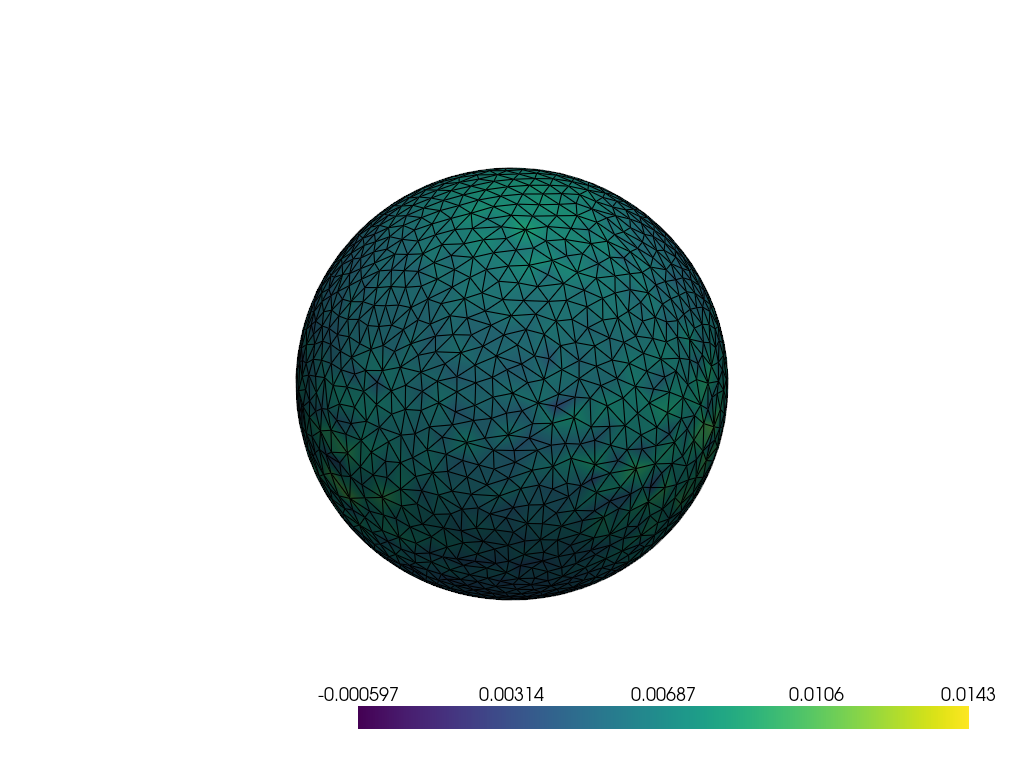

In [14]:
rbf = PHS(3)
poly_deg = 1
stencil_size = 15
trimesh = TriMesh(
    points = sphere.points, 
    simplices = hull.simplices, 
    normals = sphere.points,
)
quad = SurfaceQuad(
    trimesh=trimesh,
    rbf=rbf,
    poly_deg=poly_deg,
    stencil_size=stencil_size,
    verbose=True,
)


plt.hist(quad.weights, bins=20)
plt.xlabel("weight")
plt.ylabel("count")
plt.show()

plotter = pv.Plotter()
plotter.add_mesh(
    pv.PolyData(sphere.points, [(3, *f) for f in hull.simplices]),
    show_edges=True,
    scalars=quad.weights,
)
plotter.show()

Let's test this on a linear function
$$f_1(x,y,z) = x + y + z + 1$$
each of which integrates to $4\pi$ on the unit square.

In [17]:
def f1(points) -> np.ndarray[float]:
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]
    return x + y + z + 1

exact = 4*np.pi

f1_approx = quad.weights @ f1(quad.points)
print(f"f1 relative error = {np.abs(exact - f1_approx)/exact}")

f1 relative error = 0.0002739727311682821


Not bad. Let's check for convergence.

In [27]:
Ns = [500 * 2**i for i in range(4)][::-1]
rbf = PHS(3)
poly_deg = 1
stencil_size = 15

errors = []
for N in Ns:
    print(f"Calculating for {N=}")
    sphere = SpherePoints(N, verbose=False)
    hull = ConvexHull(sphere.points)
    trimesh = TriMesh(
        points = sphere.points, 
        simplices = hull.simplices, 
        normals = sphere.points,
    )
    quad = SurfaceQuad(
        trimesh=trimesh,
        rbf=rbf,
        poly_deg=poly_deg,
        stencil_size=stencil_size,
        verbose=False,
        tqdm_kwargs={"position": 1, "leave": False}
    )
    errors.append(np.abs(exact - quad.weights@f1(quad.points))/exact)


Calculating for N=4000
Calculating for N=2000
Calculating for N=1000
Calculating for N=500


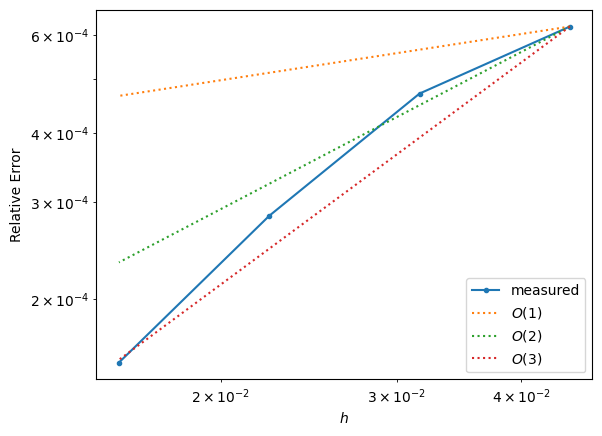

In [50]:
hs = [1/np.sqrt(N) for N in Ns]
max_err = np.max(errors)
max_h = np.max(hs)
min_h = np.min(hs)
plt.loglog(hs, errors, ".-", label="measured")
for order in range(1, 4):
    plt.loglog([max_h, min_h], [max_err, max_err * np.log(max_h)/np.log(min_h) / order], ":", label=f"$O({order})$")
plt.legend()
plt.xlabel("$h$")
plt.ylabel("Relative Error")
plt.show()